In [ ]:
from ipynb.fs.full.create_dataframe import read_data, read_atlas_data
from ipynb.fs.full.gen_atlas_data import gen_pairs

import cv2
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample
from sklearn.metrics import roc_curve, auc

In [6]:
reptiles=read_data(["Crocodile_Alligator","Gecko"])

In [7]:
pair_data=gen_pairs(2800,reptiles)
reptiles=pair_data

In [8]:
pair_data["target"].value_counts()

Salamander         596
Turtle_Tortoise    576
Snake              549
Lizard             543
Frog_Toad          536
Name: target, dtype: int64

In [9]:
frogs=reptiles[reptiles["target"]=="Frog_Toad"]

In [10]:
def basic_preprocess(dataframe):
    # Basic preprocessing 
    dataframe=dataframe[dataframe.astype(str)['image'] != '[]']

    # prepare X
    img_list = list(dataframe['image'])
    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))
                #Save arrays to a list:
                data_img.append(each_img_resized)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y

In [11]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)


X_train shape:  (1904, 128, 128, 3)
y_train shape:  (1904, 5)
X_val shape  :  (476, 128, 128, 3)
y_val shape  :  (476, 5)
X_test shape :  (420, 128, 128, 3)
y_test shape :  (420, 5)


In [12]:
def fit_model(X_train,y_train,X_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=X_train[0].shape)
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit

In [13]:
model,fit=fit_model(X_train,y_train,X_val)

2023-04-28 14:00:53.029102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/b_/yvjz1j1s62q6kv4122_dlzx80000gn/T/ipykernel_62632/3344113094.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
30/30 [==============================] - 195s 7s/step - loss: 1.5775 - accuracy: 0.2563 - val_loss: 1.6712 - val_accuracy: 0.2206
Epoch 2/10
30/30 [==============================] - 212s 7s/step - loss: 1.4050 - accuracy: 0.4202 - val_loss: 1.4701 - val_accuracy: 0.3697
Epoch 3/10
30/30 [==============================] - 226s 8s/step - loss: 1.1838 - accuracy: 0.5368 - val_loss: 1.2473 - val_accuracy: 0.4916
Epoch 4/10
30/30 [==============================] - 224s 7s/step - loss: 1.0299 - accuracy: 0.6035 - val_loss: 1.2001 - val_accuracy: 0.5000
Epoch 5/10
30/30 [==============================] - 1769s 61s/step - loss: 0.9514 - accuracy: 0.6329 - val_loss: 1.0637 - val_accuracy: 0.5798
Epoch 6/10
30/30 [==============================] - 185s 6s/step - loss: 0.8412 - accuracy: 0.6775 - val_loss: 1.0675 - val_accuracy: 0.6134
Epoch 7/10
30/30 [==============================] - 188s 6s/step - loss: 0.8079 - accuracy: 0.6864 - val_loss: 0.9038 - val_accuracy: 0.6618
Epoch 8/10


14/14 [==============================] - 10s 682ms/step


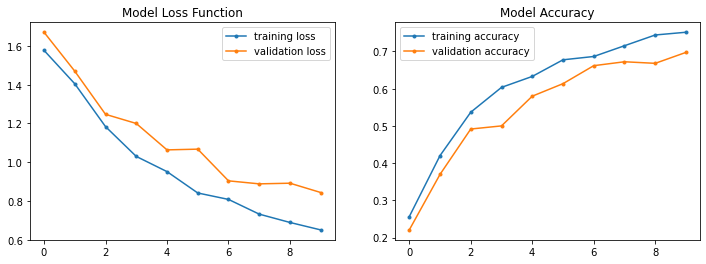

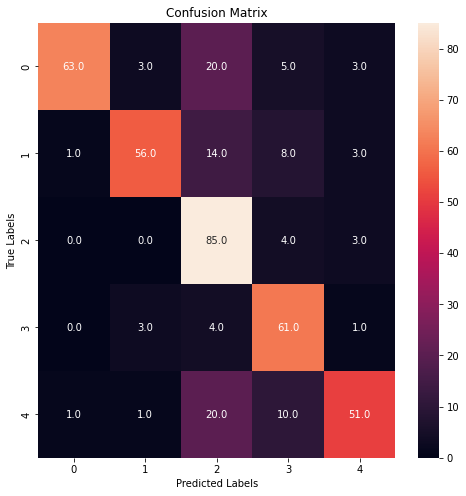

In [14]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], '.', linestyle='solid', label='training loss')
    plt.plot(history_df['val_loss'], '.', linestyle='solid', label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], '.', linestyle='solid', label='training accuracy')
    plt.plot(history_df['val_accuracy'], '.', linestyle='solid', label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model, X_test):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

make_plots(fit)
y_test_classes,y_pred_classes= getPredTestClasses(model, X_test)
make_conf_matrix(y_test_classes,y_pred_classes)

In [15]:
np.arange(0, len(reptiles), 52, dtype=int)

array([   0,   52,  104,  156,  208,  260,  312,  364,  416,  468,  520,
        572,  624,  676,  728,  780,  832,  884,  936,  988, 1040, 1092,
       1144, 1196, 1248, 1300, 1352, 1404, 1456, 1508, 1560, 1612, 1664,
       1716, 1768, 1820, 1872, 1924, 1976, 2028, 2080, 2132, 2184, 2236,
       2288, 2340, 2392, 2444, 2496, 2548, 2600, 2652, 2704, 2756])

In [16]:
reptiles=reptiles.reset_index()

In [22]:
X_test.shape

(420, 128, 128, 3)

In [17]:
def create_label_key(y,data):
    dic={}
    for s in np.arange(0, len(reptiles), 100, dtype=int):
        key_value=data["target"][s]
        key=np.where(y[s] == 1)[0][0]
        dic[key]=key_value
    return dic

predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = create_label_key(y,reptiles)
predicted=predicted.replace({"True": label_key,"Pred":label_key})

In [18]:
label_key

{1: 'Lizard',
 2: 'Salamander',
 3: 'Snake',
 0: 'Frog_Toad',
 4: 'Turtle_Tortoise'}

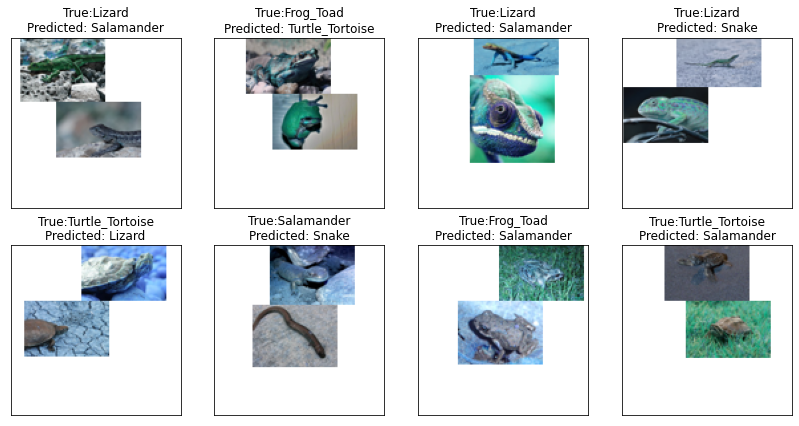

In [19]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+str(misclassified['True'].loc[each])+"\nPredicted: "+str(misclassified['Pred'].loc[each]))
        plt.xticks([])
        plt.yticks([])
        i += 1

show_sample_misclassified(predicted)

14/14 [==============================] - 10s 696ms/step


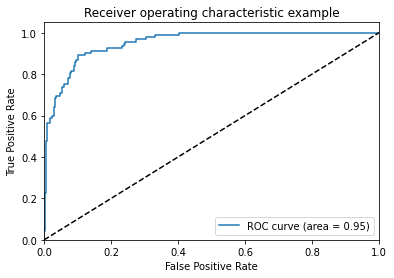

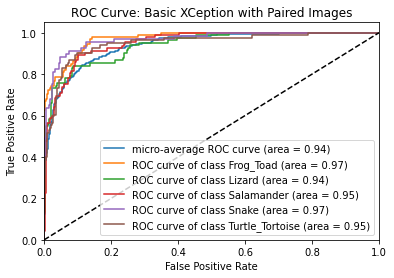

In [20]:
n_classes=reptiles["target"].nunique()
y_score=model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(label_key.get(i), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Basic XCeption with Paired Images')
plt.legend(loc="lower right")
plt.show()

In [52]:
def show_images(image_list):
    for i in image_list:
        plt.imshow(i)
        plt.pause(0.5)

def convertToArray(image_list):
    image_array_list=[]
    for i in image_list:
        image_array_list.append(np.asarray(i))
    return pd.Series(image_array_list)

def convertToImage(image_array_list):
    image_list=[]
    for i in image_array_list:
        image_list.append(Image.fromarray(i))
    return pd.Series(image_list)

In [55]:
def read_atlas_data(remove_types):

    reptiles=pd.DataFrame()

    reptile_file=os.listdir("data/atlas_test")
    for i in reptile_file:
        rep_list=[]
        if (i != ".DS_Store"):
            for j in os.listdir("data/atlas_test/"+i):
                if (j != ".DS_Store"):
                    if len(rep_list)<500:
                        rep_list.append(Image.open("data/atlas_test/"+i+"/"+j).convert("RGBA"))
        
            rep_list=convertToArray(rep_list)
            df=pd.DataFrame({"image":rep_list})

            df["target"]=i
            reptiles=pd.concat([reptiles,df])

    #remove_types=["Lizard","Toad"]
    liz_types=["Chameleon","Iguana"]
    reptiles["target"]=np.where(reptiles["target"].isin(liz_types),"Lizard",reptiles["target"])

    reptiles=reptiles[reptiles["target"].isin(remove_types)==False]
    return reptiles.reset_index()


In [94]:
atlas_test = read_atlas_data(["Crocodile_Alligator","Gecko"])
atlas_test.target.value_counts()
X_atlas, y_atlas = basic_preprocess(atlas_test)

In [96]:
atlas_test

,index,image,target
0,0,"[[[151, 147, 144, 255], [105, 101, 98, 255], [...",Frog_Toad
1,0,"[[[102, 81, 76, 255], [100, 79, 74, 255], [101...",Turtle_Tortoise
2,1,"[[[218, 208, 209, 255], [219, 209, 210, 255], ...",Turtle_Tortoise
3,0,"[[[236, 237, 241, 255], [234, 235, 239, 255], ...",Salamander
4,1,"[[[192, 165, 156, 255], [193, 164, 156, 255], ...",Salamander
5,0,"[[[5, 5, 57, 255], [14, 14, 66, 255], [6, 6, 5...",Snake
6,1,"[[[145, 196, 78, 255], [127, 174, 70, 255], [6...",Snake
7,2,"[[[77, 67, 5, 255], [78, 67, 11, 255], [66, 56...",Snake


In [95]:
y_atlas

array([[1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]], dtype=int8)

In [99]:
atlas_label_key = {0: "Frog_Toad",
                   1: "Salamander",
                   2: "Snake",
                   3: "Turtle_Tortoise",
                   4: "Lizard"}

In [100]:
atlas_y_test_classes,atlas_y_pred_classes= getPredTestClasses(model, X_atlas)

1/1 [==============================] - 0s 281ms/step


In [101]:
atlas_y_pred = model.predict(X_atlas)
atlas_y_pred_classes = np.argmax(atlas_y_pred, axis = 1)
atlas_y_test_classes = np.argmax(y_atlas, axis = 1)
atlas_predicted=pd.DataFrame({"True":atlas_y_test_classes,"Pred":atlas_y_pred_classes})
atlas_predicted=atlas_predicted.replace({"True": atlas_label_key,"Pred":atlas_label_key})

1/1 [==============================] - 0s 347ms/step


In [103]:
%config InlineBackend.figure_format = 'retina'

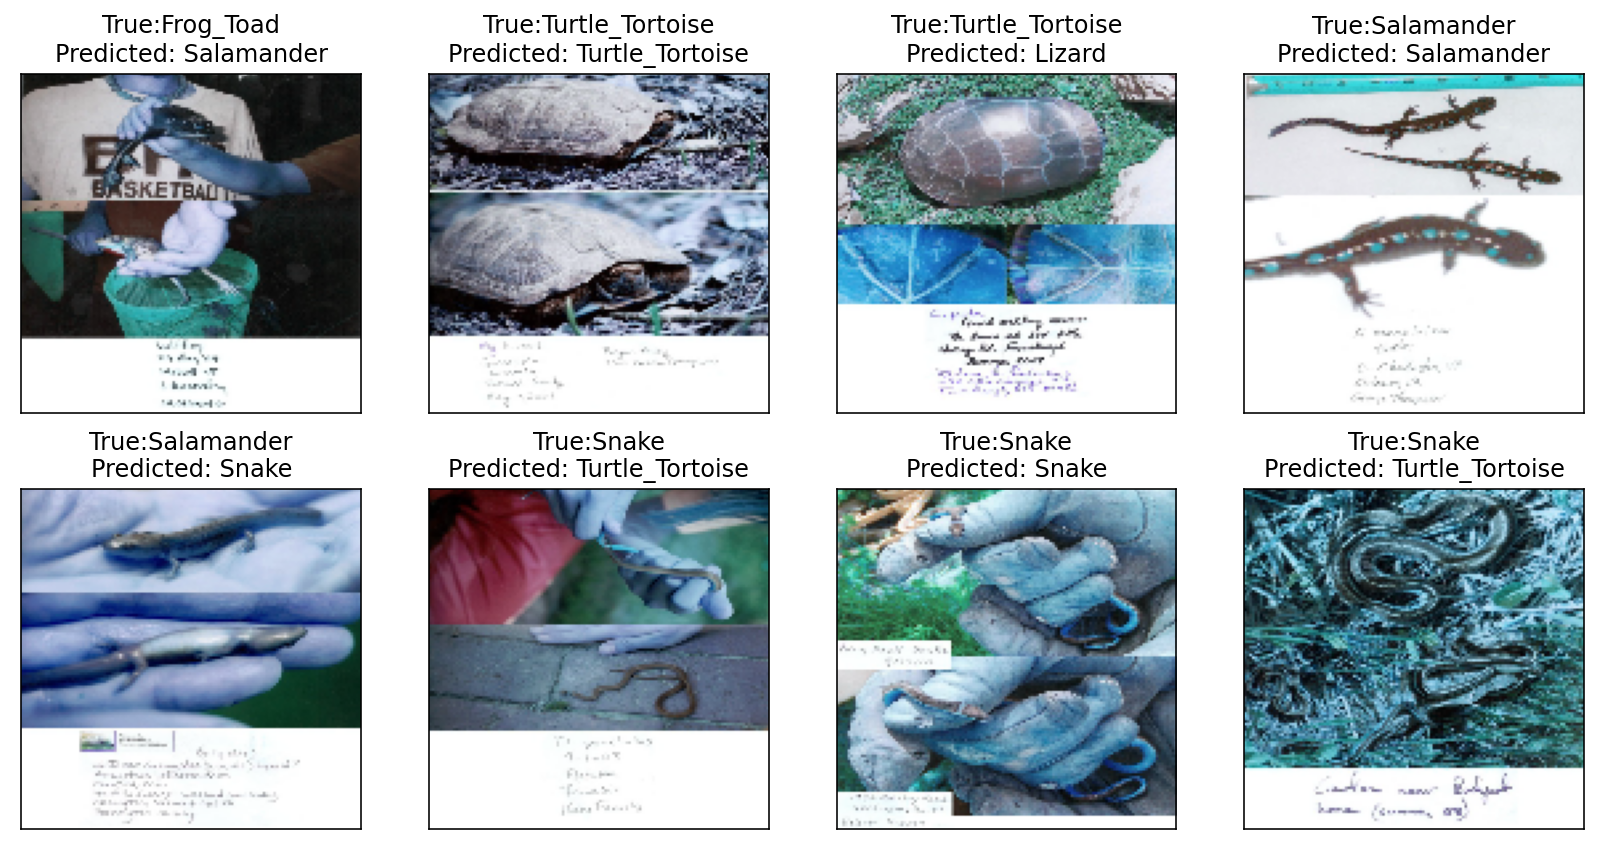

In [104]:
plt.figure(figsize=(14,7))
i = 1
for each in range(8):
    plt.subplot(2,4,i)
    plt.imshow(Image.fromarray(X_atlas[each]))
    plt.title("True:"+str(atlas_predicted['True'].loc[each])+"\nPredicted: "+str(atlas_predicted['Pred'].loc[each]))
    plt.xticks([])
    plt.yticks([])
    i += 1